In [4]:
#Read in Packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from geopandas import GeoDataFrame
from numpy.random import RandomState, uniform
import string
from sodapy import Socrata
import seaborn as sns
import networkx as nx
from networkx.algorithms import community
import community.community_louvain as community
from datetime import datetime
from pytz import timezone
import statsmodels.api as sm
import json
%matplotlib inline

print('Imports Complete')

Imports Complete


# The goal of this notebook was to perform a network analysis on the Trips dataset, using the census tracts as nodes, and the start and end locations of each trip to identify connections 

- Based on this network analysis, I will be able to cluster the nodes in the network based on connections
- It is my hypothesis that nodes in the same community clusters will have similar patterns in rideshare volume across time
- This will allow me to perofrm model selection by testing on just 4 clusters, as opposed to 800 different census tracts

# Read in dataframe files from the data cleansing script and shape files

In [152]:
#Read in map of Chicago
chicago_map=gpd.read_file(r'C:\Users\brandin_hirsch\Desktop\chicago\geo_export_e91837ed-0772-4931-9304-2631f6936d17.shp')

#Read in network nodes and edge values
df_network_values=pd.read_csv(r'C:\Users\brandin_hirsch\Desktop\network_node_values_nov_march.csv')

#Read in node weights
df_network_weights=pd.read_csv(r'C:\Users\brandin_hirsch\Desktop\network_weights_nov_march.csv')

#Read in df of all time series
df_trips_all_locations=pd.read_csv(r'C:\Users\brandin_hirsch\Desktop\full_data_nov_march.csv',usecols=['time','census_tract','trip_count'])

#Read in position data for each census tract
pos_data=pd.read_csv(r'C:\Users\brandin_hirsch\Desktop\pos_data_v3.csv')

In [153]:
#Create network node coordinate dictionary
mx, my = pos_data['Long'].values, pos_data['Lat'].values
pos = {}
for count, elem in enumerate (pos_data['census_tract']):
     pos[elem] = (mx[count], my[count])
        


# Begin Network Analysis

<br>
<br>

# The below networks show a non-directional network without any positional inputs, and a network using the lat and long coordinates as positional values

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


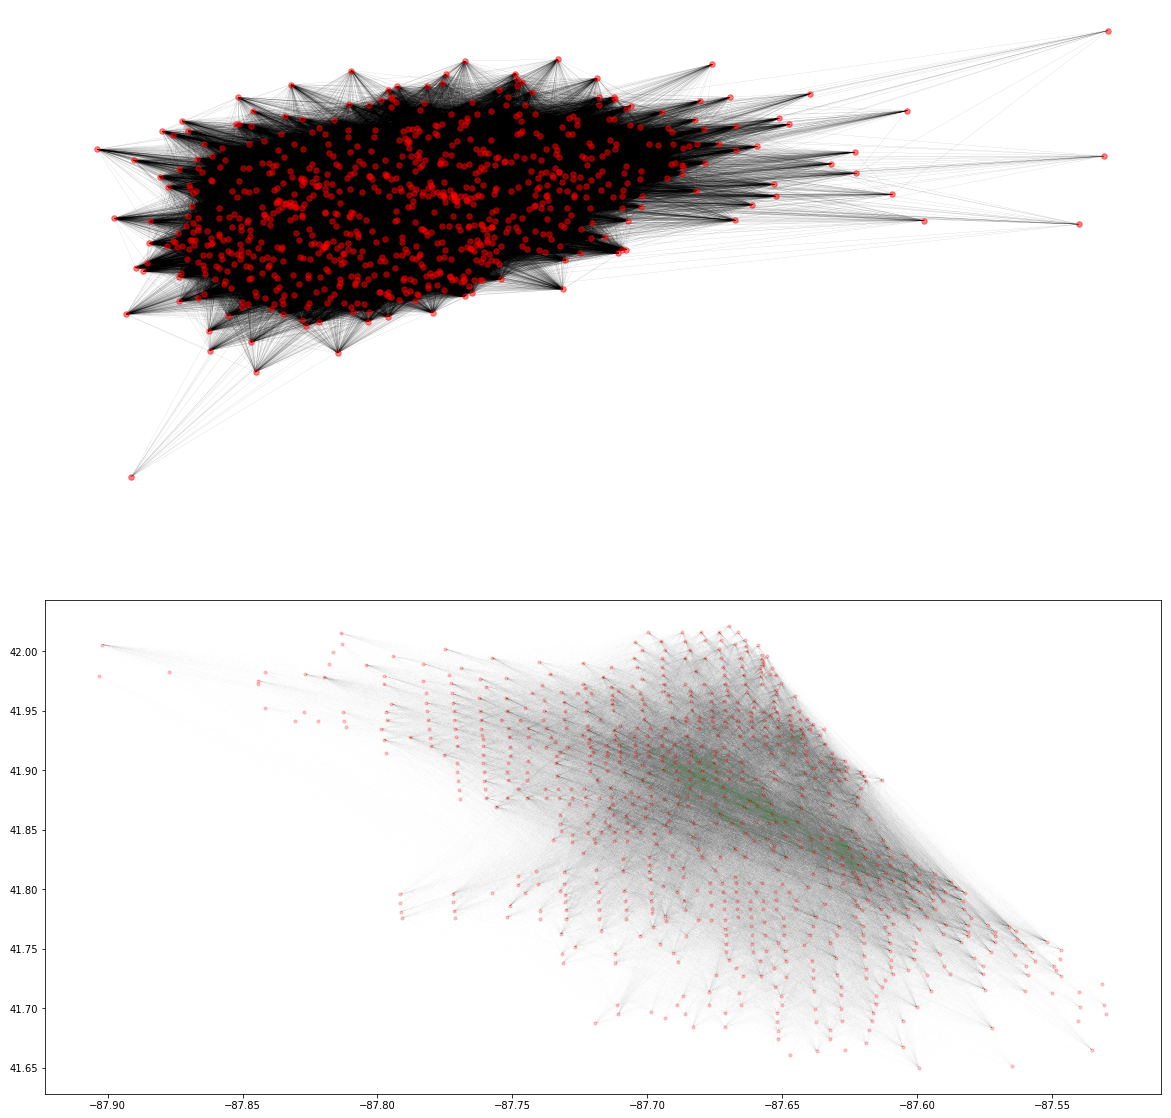

In [49]:
#Create non-directional network analysis
data_nwk =nx.Graph()
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (20,20))

G = nx.convert_matrix.from_pandas_edgelist(df_network_values, source='start_location', target='end_location',edge_attr='trip_count',create_using=data_nwk)


#Plot Analysis 

#Draw non directional graph
nx.draw(G, arrowsize=1,with_labels=False,node_size=30,alpha=.5,width=.1,ax=ax1)

#Draw graph in shape of Chicago
nx.draw_networkx_nodes(G, pos = pos, node_list = G.nodes(),node_color = 'r', alpha = 0.2, node_size = 10,ax=ax2)

nx.draw_networkx_edges(G, pos = pos, edge_color='g', alpha=.12, arrows = False,width=.015,ax=ax2)


In [50]:
#Use weights for node size to visually represent traffic volume 

#Create dataframe of the nodes from the network
node_list=pd.DataFrame(list(G.nodes))

node_list.columns=['census_tract']

node_weights=pd.merge(node_list,df_network_weights,how='left',on='census_tract')

node_weights['weight']=node_weights.trip_count/sum(node_weights.trip_count)*60000

node_weights=list(node_weights.weight)

# Here I read in a map of Chicago so that we can plot the network nodes on the map for a better visual!

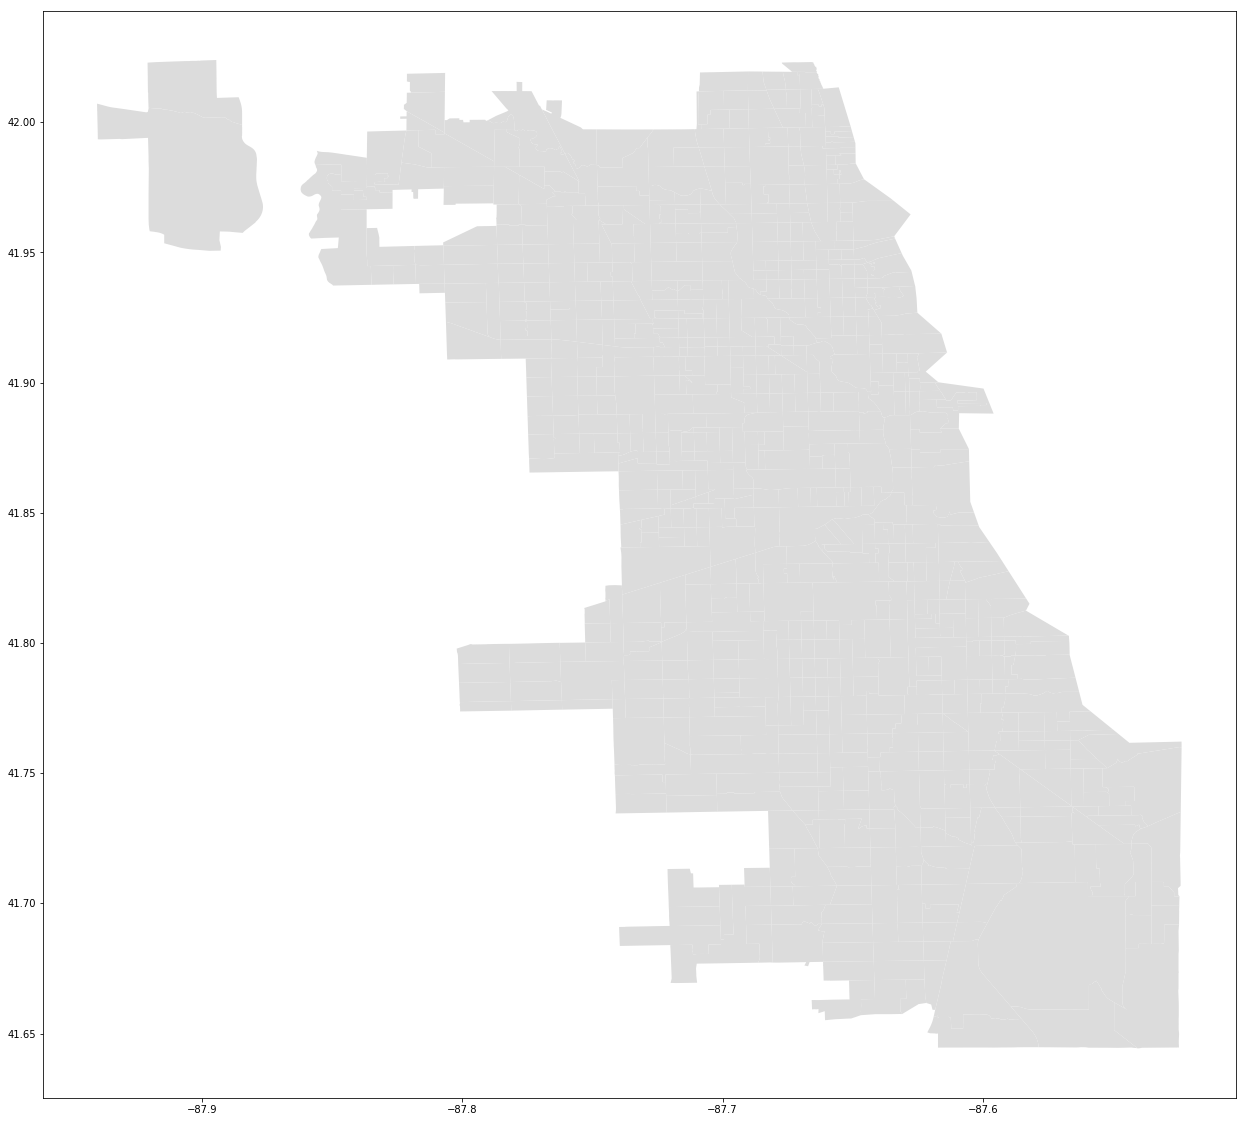

In [51]:
#Plot Map of Chicago

fig,ax=plt.subplots(figsize=(25,20))

chicago_map.plot(ax=ax,color='gainsboro')

# Using the number of rides in each node as the node size, we can visually see which census tracts have the highest overall volume of rideshare traffic across time

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


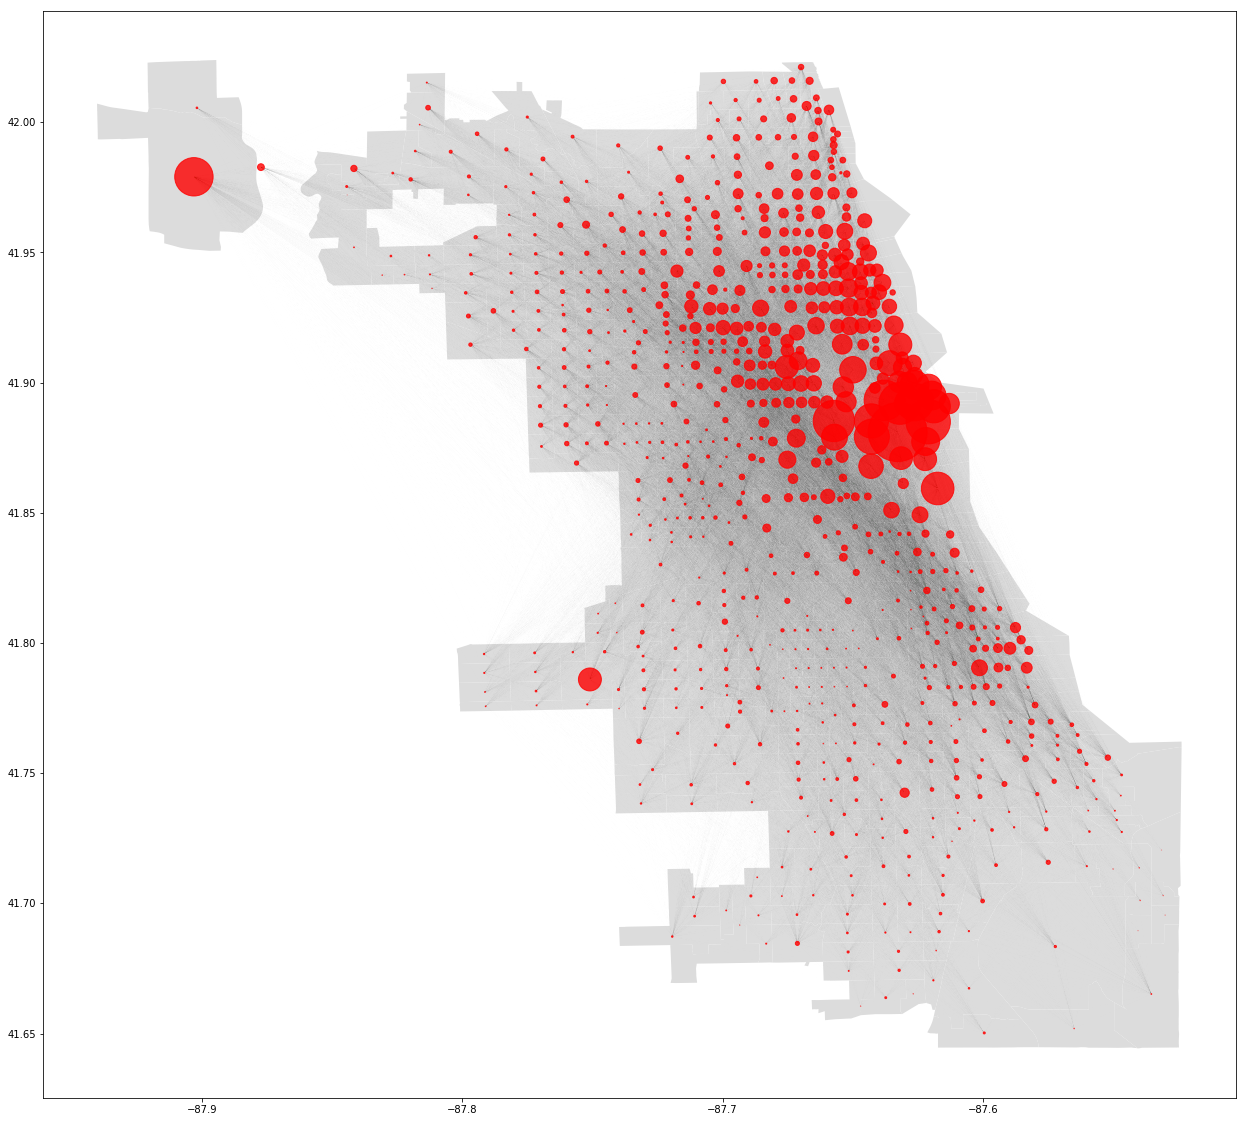

In [52]:
#Draw network on map of chicago with weights
fig,ax=plt.subplots(figsize=(25,20))
chicago_map.plot(ax=ax,color='gainsboro')
nx.draw_networkx_nodes(G, pos = pos, node_list = G.nodes(),node_color = 'red', alpha = 0.8, node_size = node_weights,ax=ax)
nx.draw_networkx_edges(G, pos = pos, edge_color='green', alpha=.09, arrows = False,width=.018,ax=ax)

# Here we can create clusters based on connections between each node. This algorithm aims to create communities who are more connected to nodes within themselves than other communities

In [53]:
#Louvain Modularity Method for discovering underlying communities
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


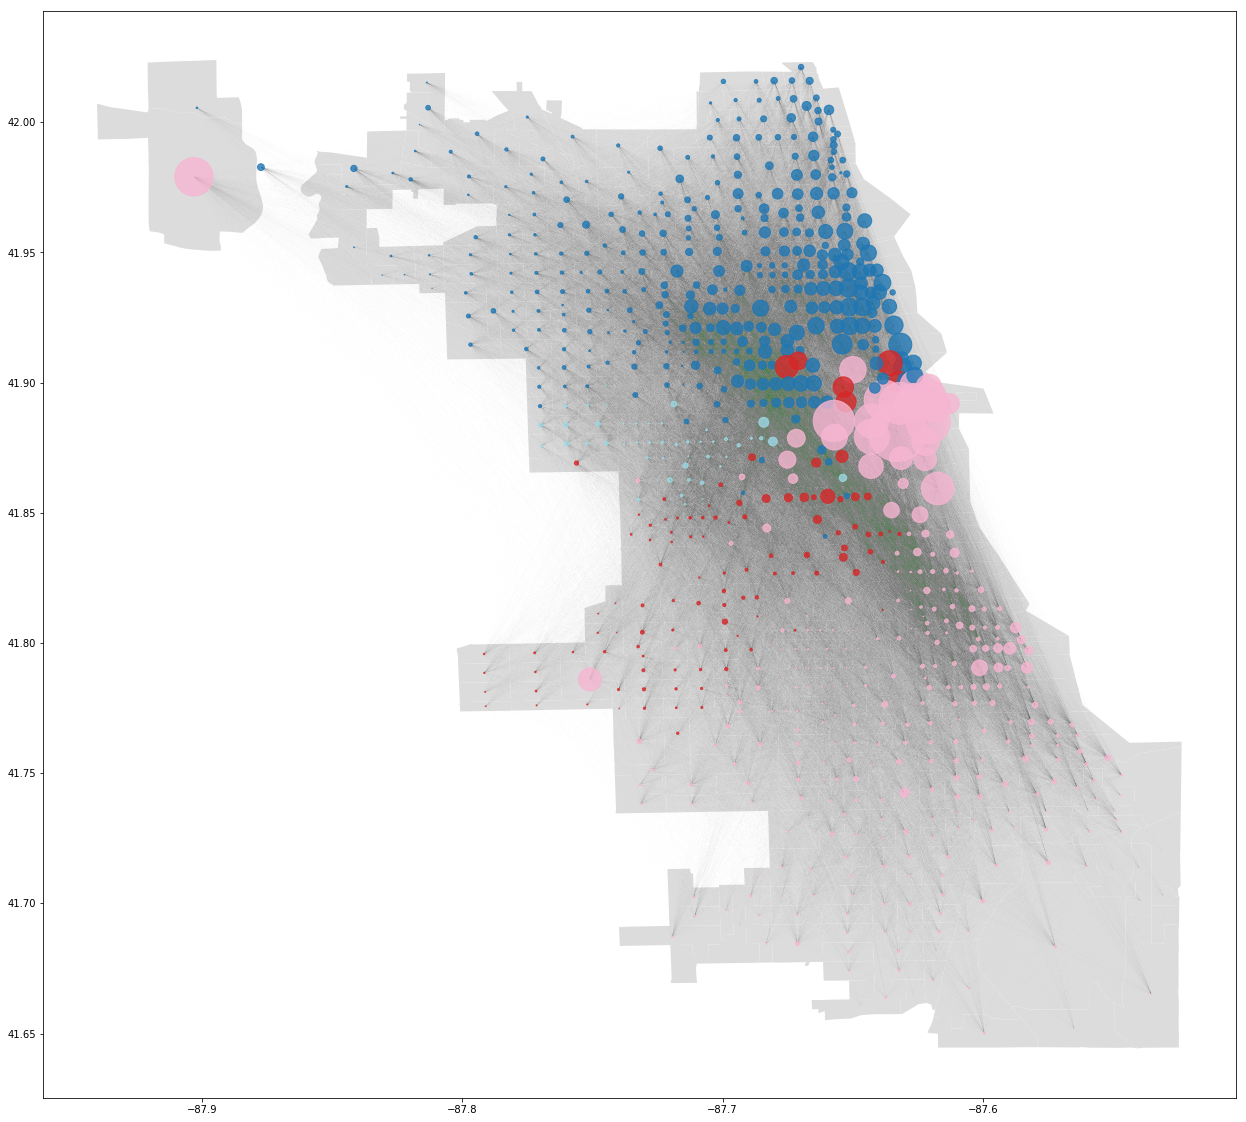

In [54]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(25,20))

chicago_map.plot(ax=ax,color='gainsboro')


nx.draw_networkx_nodes(G, pos = pos, node_list = G.nodes(),node_color = values, alpha = .8, node_size = node_weights,ax=ax,cmap='tab20')
nx.draw_networkx_edges(G, pos = pos, edge_color='green', alpha=.094, arrows = False,width=.019,ax=ax)

In [56]:
#Create dataframe of nodes and communities

#Create list of nodes
nodes=list(G.nodes())

#Create communities dataframe using list of nodes and list of community values from Louvain Modularity Method
df_communities=pd.DataFrame({'community_name':values,'census_tract':nodes})

df_communities.community_name=df_communities.community_name.astype(str)

df_communities.community_name.unique()

array(['0', '1', '2', '3'], dtype=object)

# Identify the cluster (community) for each row in the main dataset

In [86]:
#Join each row in the full dataset to their communities based on census tract
df_trips_all_locations_communities=df_trips_all_locations.merge(df_communities,how='left', left_on='census_tract',right_on='census_tract')

df_trips_all_locations_communities.drop(labels=['index'],inplace=True,axis=1)

df_trips_all_locations_communities.head()

,Unnamed: 0,time,census_tract,trip_count,community_name
0,0,12/31/2018 12:45:00 PM,17031980100,5,2
1,65,12/31/2018 12:45:00 PM,17031230900,2,0
2,96,12/31/2018 12:45:00 PM,17031830900,10,0
3,95,12/31/2018 12:45:00 PM,17031980000,30,2
4,94,12/31/2018 12:45:00 PM,17031843700,1,0


In [2]:
community_graph_df=pd.DataFrame(df_trips_communities.groupby('community_name')['trip_count'].sum())

community_graph_df.reset_index(inplace=True)

community_graph_df.head()

# Let's slice the main dataframe by community to create 4 new dataframes, and observe a small piece of time series data

# Note the strong daily and weekly seasonality 

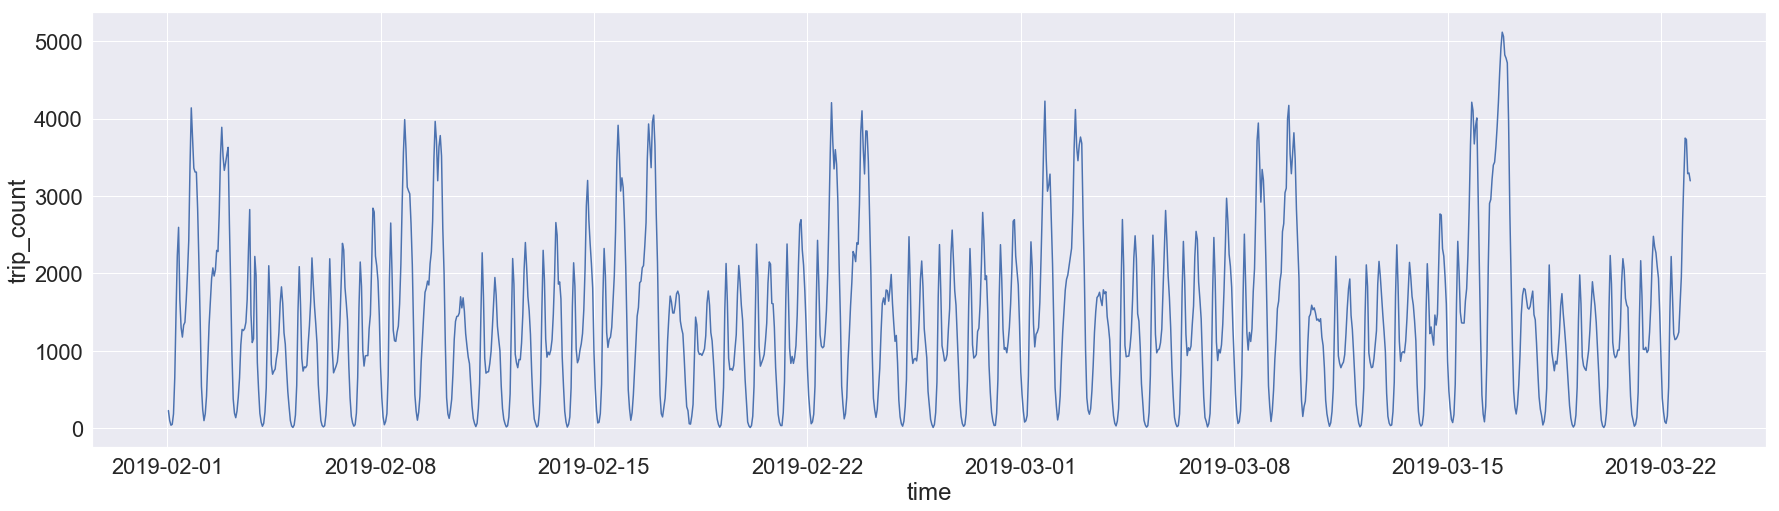

In [191]:
#Setup Seaborn Plot
sns.set(font_scale=2)
fig, ax = plt.subplots(1,1,figsize=(30,8))


#Group together the  by community name and trip start time
df_trips_communities=pd.DataFrame(df_trips_communities.groupby(['time','community_name'])['trip_count'].sum())
df_trips_communities.reset_index(inplace=True)

#Convert trip start time to date, take out the minutes,leave it as a pandas object for further group bys
df_trips_communities['time']=pd.to_datetime(df_trips_communities['time'],infer_datetime_format=True)

df_trips_communities.sort_values(by='time',inplace=True)

df_trips_communities['time']=df_trips_communities['time'].dt.strftime('%Y-%m-%d %H')


#Select all the separate communities and their pickup data
df_community_0=df_trips_communities[df_trips_communities['community_name']=='0']

df_community_1=df_trips_communities[df_trips_communities['community_name']=='1']

df_community_2=df_trips_communities[df_trips_communities['community_name']=='2']

df_community_3=df_trips_communities[df_trips_communities['community_name']=='3']


#Function to group each dataframe by community and hour
def group_community(community):
    
    community=pd.DataFrame(community.groupby(['community_name','time'])['trip_count'].sum())
    
    community.reset_index(inplace=True)
    
    community['time']=pd.to_datetime(community['time'],infer_datetime_format=True)
    
    return community



df_community_0=group_community(df_community_0)

df_community_1=group_community(df_community_1)

df_community_2=group_community(df_community_2)

df_community_3=group_community(df_community_3)


#Plot a few days from community 0
mask=(df_community_1['time']> '2019-02-01 00') & (df_community_1['time']< '2019-03-23 00')

df_pickup_community2_0=df_community_1[mask]


sns.lineplot(x='time',y='trip_count',data=df_pickup_community2_0)

# Lastly, I'll export the newly created datasets for time series forecasting model selection

In [188]:
#Fix community 3 which is missing some hours

placeholder=pd.DataFrame()

placeholder['time']=df_community_0.time

placeholder=placeholder.merge(df_community_3,how='left',on='time')

placeholder.fillna(0,inplace=True)

placeholder['community_name']=3

df_community_3=placeholder



#Change community dfs to datetime dfs
community_list=[df_community_0,df_community_1,df_community_2,df_community_3]

for i,com in enumerate(community_list):
    com.set_index('time',inplace=True)
    
    com=com.drop(labels='community_name',axis=1)
    
    com.trip_count=com.trip_count.astype(float)
    
    i=str(i)
    
    com.name=i
    
    com.to_csv(r'C:\Users\brandin_hirsch\Desktop'+'\\'+'df_community_'+com.name+'.csv')
    
    print(com.name)

0
1
2
3


In [ ]:
#Write to csv the dataframe of all trips and their community clusters
df_trips_all_locations_communities.to_csv(r'C:\Users\brandin_hirsch\Desktop\trips_all_locations_communities_nov_march.csv')